Mount Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")
!pwd
!ls

%cd /content/drive/My\ Drive/Colab\ Notebooks/
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
drive  sample_data
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks
Fingerprint-Recognition.ipynb		SOCOFingdataset		

In [2]:
input_path = 'content/drive/My Drive/Colab Notebooks/SOCOFing/'
real_path = '/content/drive/My Drive/Colab Notebooks/SOCOFing/Real/'
altered_path = '/content/drive/My Drive/Colab Notebooks/SOCOFing/Altered/'

In [3]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import imutils
from os import listdir
import time

%matplotlib inline

Split dataset

In [4]:
def split_data(x, y, test_size=0.2):
    x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=test_size)
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5)

    return x_train, y_train, x_val, y_val, x_test, y_test

Load data

In [5]:
def load_data(dir_list, image_size):
  x = []
  y = []
  image_width, image_height = image_size

  for directory in dir_list:
    flist = listdir(directory)
    for f in flist:
      img = cv2.imread(directory + '/' + f)
      img = cv2.resize(img, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
      img = img / 255.0
      x.append(img)

      if directory[-5:-1] != 'Real':
        y.append(0)
      else:
        y.append(1)

  x = np.array(x)
  y = np.array(y)

  x, y = shuffle(x, y)

  return x, y

In [6]:
x, y = load_data([real_path, altered_path], (96, 103))
x_train, y_train, x_val, y_val, x_test, y_test = split_data(x, y, test_size=0.2)

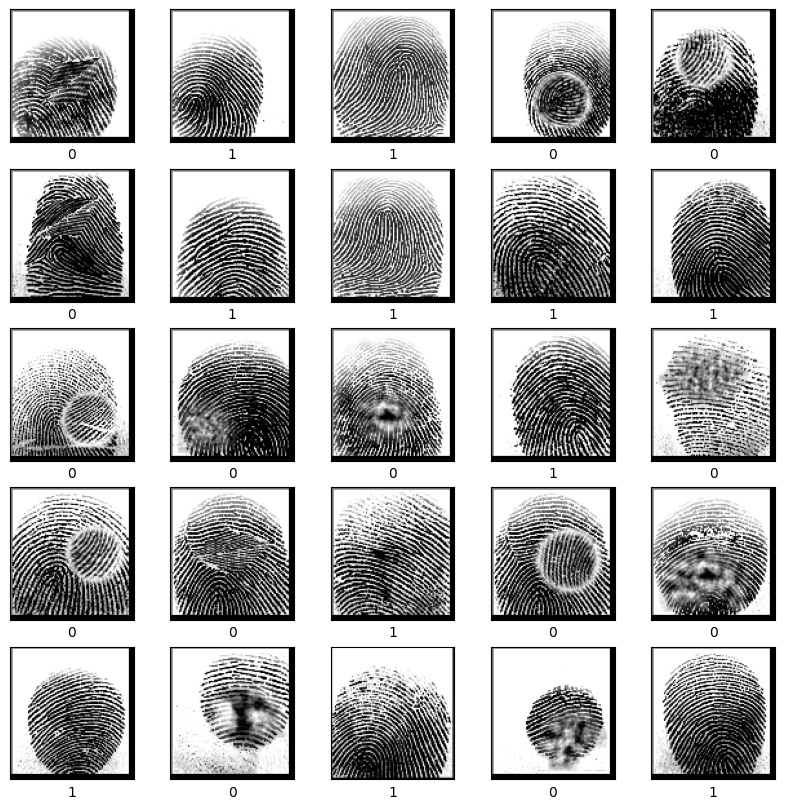

In [7]:
class_names = ['Real', 'Altered']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(y_train[i])
plt.show()


Create convolutional base

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(103, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 101, 94, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 20, 64)        36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 56320 

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 101, 94, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 20, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 28160)             0

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 32, epochs=100,
                    validation_data=(x_val, y_val))

Epoch 1/100
50/50 [==============================] - 5s 23ms/step - loss: 0.5958 - accuracy: 0.7206 - val_loss: 0.4207 - val_accuracy: 0.8050
Epoch 2/100
50/50 [==============================] - 1s 14ms/step - loss: 0.3762 - accuracy: 0.8388 - val_loss: 0.2823 - val_accuracy: 0.8750
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 0.2936 - accuracy: 0.8763 - val_loss: 0.2430 - val_accuracy: 0.9000
Epoch 4/100
50/50 [==============================] - 1s 14ms/step - loss: 0.2883 - accuracy: 0.8763 - val_loss: 0.2488 - val_accuracy: 0.8950
Epoch 5/100
50/50 [==============================] - 1s 13ms/step - loss: 0.2382 - accuracy: 0.8894 - val_loss: 0.2979 - val_accuracy: 0.8700
Epoch 6/100
50/50 [==============================] - 1s 13ms/step - loss: 0.2143 - accuracy: 0.9100 - val_loss: 0.1944 - val_accuracy: 0.9200
Epoch 7/100
50/50 [==============================] - 1s 14ms/step - loss: 0.1848 - accuracy: 0.9269 - val_loss: 0.2248 - val_accuracy: 0.9100
Epoch 

7/7 - 0s - loss: 0.1382 - accuracy: 0.9700 - 65ms/epoch - 9ms/step


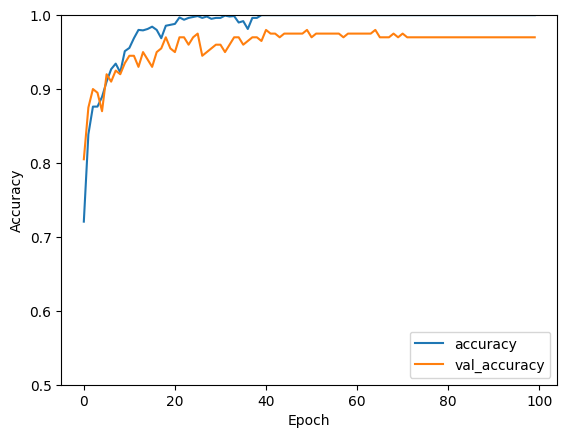

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)

In [12]:
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

accuracy = tf.keras.metrics.Accuracy()(y_test, y_pred_argmax)
precision = tf.keras.metrics.Precision()(y_test, y_pred_argmax)
recall = tf.keras.metrics.Recall()(y_test, y_pred_argmax)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy: %", format(accuracy.numpy()*100))
print("Precision: %", format(precision.numpy()*100))
print("Recall: %", format(recall.numpy()*100))
print("F1-score: %", format(f1.numpy()*100))

7/7 [==============================] - 0s 5ms/step
Accuracy: % 98.50000143051147
Precision: % 98.01980257034302
Recall: % 99.00000095367432
F1-score: % 98.50746393203735


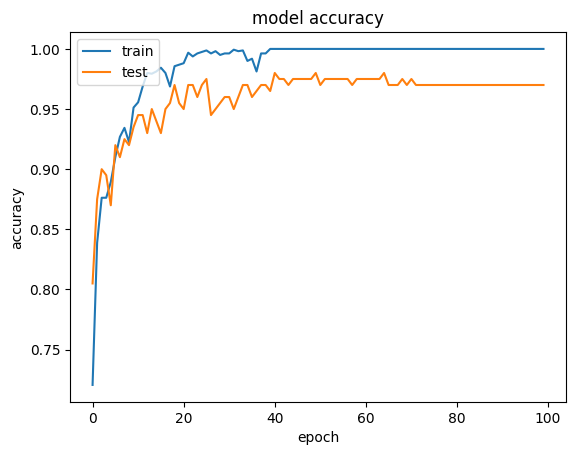

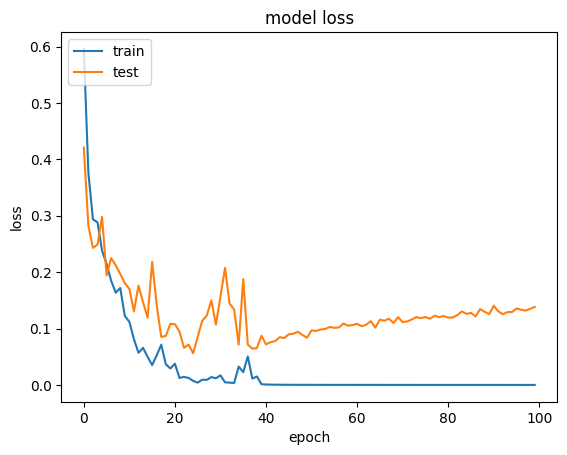

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()